# Fetching crypto and tweets data.

In [1]:
from sklearn.preprocessing import OrdinalEncoder
from TweetScraper import TweetScraper
from CryptoApi import CryptoApi
import pandas as pd
import numpy as np
import re


# scrp = TweetScraper(start='2023-05-04', end='2023-05-14', maxEmptyPages=2, max_workers=8)
# new_tweets = scrp.parallel_download_tweets()
# new_twt = pd.DataFrame(new_tweets)


# with open('crypto_token.txt','r') as f:
#     token = f.readline()
    
# crypto = CryptoApi(token)
# crypto.get_data('btc','usd','day',period_count=90)

# Analysis of tweets

In [2]:
# new_tweets_df = TweetScraper().fetch_data('2023-04-10','2023-06-09', frequency='d')
# cleaned_df = TweetCleaner().transform(new_tweets_df)
# nlp_model = LDA().fit(cleaned_df)
# cleaned_df = extract_topics(nlp_model.topics)

# new_btc_df = CryptoApi().fetch_data()
# cleaned_btc = CryptoCleaner().transform(new_btc_df)
# xgb_model = XGBoost().fit(cleaned_btc)

In [3]:
from DataPreparation.CryptoPreprocessor import CryptoPreprocessor
from DataPreparation.TweetPreprocessor import TweetPreprocessor
from DataPreparation.TextVectorizer import TextVectorizer
from gensim.test.utils import datapath
from gensim.models import LdaMulticore


tweets_df = pd.read_csv(r'Data/elon_tweets.csv', index_col=0)
twt_prep = TweetPreprocessor(tweets_df)
mod_tweets_df = twt_prep.transform()

text2vec = TextVectorizer()
preprocessing_pipeline = text2vec.make_pipeline()
id2word, corpus = preprocessing_pipeline.transform(mod_tweets_df['rawContent'].values.tolist())

In [4]:
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs


def black_box_function(x, y):
    """Function with unknown internals we wish to maximize.

    This is just serving as an example, for all intents and
    purposes think of the internals of this function, i.e.: the process
    which generates its output values, as unknown.
    """
    return -x ** 2 - (y - 1) ** 2 + 1

def optimize_bayes(func, pbounds=None, verbose=2):
    if pbounds==None:
        pbounds = {'x': (2, 12), 'y': (-15, 15)}
        
    optimizer = BayesianOptimization(
        f=func,
        pbounds=pbounds,
        verbose=verbose, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
        random_state=1,
    )
    # optimizer.maximize(init_points=2,n_iter=3)
            
    # for i, res in enumerate(optimizer.res):
    #     print(f"Iteration {i}:\n{res}")
                
    # optimizer.set_bounds(new_bounds={"x": (-2, 3)})
    optimizer.maximize(init_points=0, n_iter=15)
            
    # optimizer.probe(params={"x": 0.5, "y": 0.7}, lazy=True)
    
    logger = JSONLogger(path="./logs.log")
    optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)
    optimizer.maximize(init_points=2,n_iter=3)

    
optimize_bayes(func=black_box_function, verbose=2)

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
| 1         | -68.54    | 6.17      | 6.61      |
| 2         | -32.87    | 3.088     | -3.934    |
| 3         | -119.6    | 10.3      | 4.804     |
| 4         | -19.41    | 3.493     | 3.864     |
| 5         | -52.89    | 2.861     | 7.761     |
| 6         | -158.9    | 5.956     | -10.16    |
| 7         | -3.768    | 2.0       | 0.1238    |
| 8         | -339.0    | 12.0      | 15.0      |
| 9         | -37.78    | 5.997     | -0.6789   |
| 10        | -4.84     | 2.0       | 2.357     |
| 11        | -6.053    | 2.654     | 1.102     |
| 12        | -3.02     | 2.0       | 1.142     |
| 13        | -3.015    | 2.0       | 0.8758    |
| 14        | -3.059    | 2.0       | 1.243     |
| 15        | -3.013    | 2.0       | 0.8849    |
| 16        | -3.005    | 2.0       | 0.9285    |
|   iter    |  target   |     x     |     y     |
-------------------------------------------------


In [5]:
new_optimizer = BayesianOptimization(f=black_box_function,
                                     pbounds={"x": (-2, 2), "y": (-2, 2)},
                                     verbose=2,
                                     random_state=7)
print(len(new_optimizer.space))

0


In [6]:
load_logs(new_optimizer, logs=["./logs.log.json"])
print("New optimizer is now aware of {} points.".format(len(new_optimizer.space)))

New optimizer is now aware of 5 points.


In [7]:
new_optimizer.maximize(
    init_points=0,
    n_iter=10,
)

|   iter    |  target   |     x     |     y     |
-------------------------------------------------


| 1         | -3.088    | -2.0      | 0.7041    |
| 2         | -12.0     | -2.0      | -2.0      |
| 3         | -0.09238  | -0.3039   | 2.0       |
| 4         | -3.687    | -1.932    | 1.976     |
| 5         | -1.395    | 0.1033    | -0.544    |
| 6         | 0.9575    | 0.17      | 0.8834    |
| 7         | 0.6536    | -0.5724   | 0.8629    |
| 8         | 0.9359    | -0.01227  | 1.253     |
| 9         | 0.9618    | -0.07542  | 0.8198    |
| 10        | 0.989     | -0.0929   | 1.049     |


In [8]:
temp_file = datapath(r"D:\Projects\ElonMuskCrypto\Models\NLPmodels\lda")
lda_model = LdaMulticore.load(temp_file)

btc_df = pd.read_csv('Data/btc_data.csv', index_col=0)
crypto_prep = CryptoPreprocessor()
topics_btc = crypto_prep.transform(lda_model, mod_tweets_df, btc_df)


To drop:
retweetedTweet     0.000000
coordinates        0.000000
place              0.000000
hashtags           0.002238
card               0.041658
viewCount          0.119786
quoted_text        0.030138
quoted_username    0.030138
dtype: float64

To drop:
conversionSymbol    0.0
dtype: float64


Text(0.5, 1.0, 'open by month')

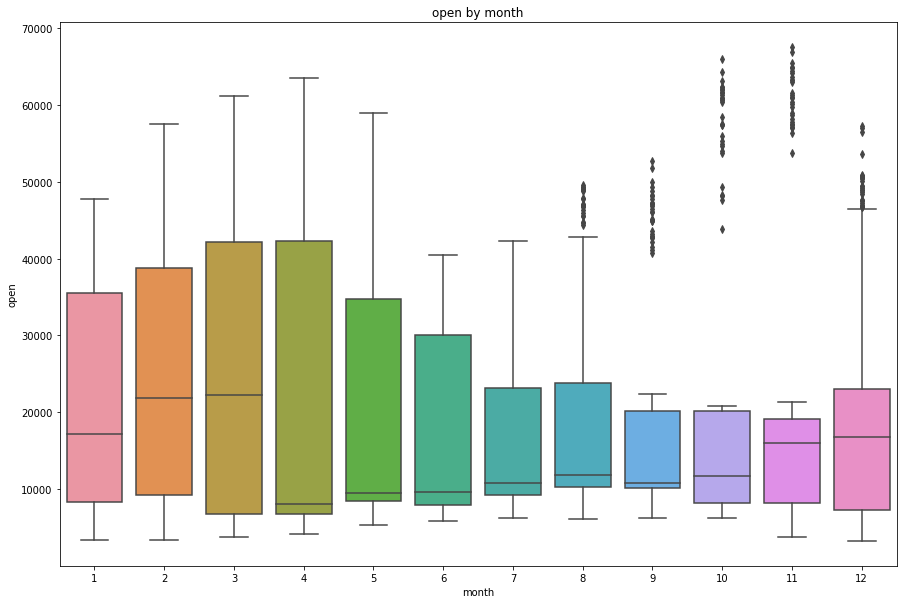

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(data=topics_btc, x='month',y='open')
ax.set_title('open by month')

In [447]:
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import precision_score


X = topics_btc.copy()
X["tomorrow"] = X["close"].shift(-1)
X["target"] = (X["tomorrow"] > X["close"]).astype(int)

target = 'target'
predictors = [col for col in X if col not in ['target', 'tomorrow']]

tss = TimeSeriesSplit(n_splits=6)
baseline_model = RandomForestClassifier(n_estimators=100, min_samples_split=25, random_state=1, n_jobs=-1)
baseline_nan_model = HistGradientBoostingClassifier(random_state=1)

def backtest(X, predictors, model):
    scores = []
    for i, (train_idx, test_idx) in enumerate(tss.split(X)):
        train = X.iloc[train_idx]
        test  = X.iloc[test_idx]        
        
        model.fit(train[predictors], train['target'])
        preds = model.predict(test[predictors])
        preds = pd.Series(preds, index=test.index)
        scores.append(precision_score(test['target'], preds))
        
    return scores

scores = backtest(X, predictors, baseline_model)        
print(scores) 
print(f'mean = {np.mean(scores)}')

[0.546875, 0.503448275862069, 0.5087719298245614, 0.5818181818181818, 0.5133333333333333, 0.48044692737430167]
mean = 0.5224489413687411


In [448]:
# horizons = [2,5,10,15,20,25]
horizons = [2,5,60,250]
new_predictors = []

for horizon in horizons:
    rolling_average = X.rolling(horizon).mean()
    
    ratio_column = f'close_ratio{horizon}'
    X[ratio_column] = X['close'] / rolling_average['close']
    
    trend_column = f'Trend_{horizon}'
    X[trend_column] = X.shift(1).rolling(horizon).sum()['target']
    
    new_predictors += [ratio_column, trend_column]
    # new_predictors += [ratio_column]

In [449]:
len(X.dropna())

1507

In [450]:
new_scores = backtest(X.dropna(), predictors+new_predictors, baseline_model)
print(new_scores) 
print(f'mean = {np.mean(new_scores)}')

[0.5, 0.6033057851239669, 0.578125, 0.5874125874125874, 0.50625, 0.45]
mean = 0.5375155620894257


In [451]:
new_scores = backtest(X, predictors+new_predictors, baseline_nan_model)
print(new_scores) 
print(f'mean = {np.mean(new_scores)}')

[0.5511811023622047, 0.415929203539823, 0.575, 0.5985401459854015, 0.48507462686567165, 0.5035460992907801]
mean = 0.5215451963406469


In [452]:
new_scores = backtest(X.dropna(), predictors+new_predictors, baseline_nan_model)
print(new_scores) 
print(f'mean = {np.mean(new_scores)}')

[0.52, 0.5943396226415094, 0.5526315789473685, 0.544, 0.5078125, 0.48120300751879697]
mean = 0.5333311181846124


In [453]:
#TODO: make tracker for features that were dropped due to high sparsity in case of leaving threshold of 50% sparsity
# for future model upgrading and adding new features.